In [5]:
%run setup.py

# Read in Kepler sample

In [6]:
stars = pd.read_excel(work_dir+'sample/clumps.xlsx')

## Define useful selections

In [7]:
# Select all very-low-mass HeB stars
lidx = (stars['Phase']==2) & (stars['ifclump']==1) & (np.abs(stars['dist_mass_sig'])>1)

# Select all under-luminous HeB stars
uidx = (stars['Phase']==2) & (stars['ifclump']==2) & (np.abs(stars['dist_nike_sig'])>1)

# Select regular stars
oidx = (stars['Phase']==2) & (stars['ifclump']!=-1) & (~lidx) & (~uidx)

# all stars
heb = lidx | uidx | oidx

print('very-low-mass stars', np.sum(lidx))
print('under-luminous stars', np.sum(uidx))
print('regular stars', np.sum(oidx))
print('all HeB stars', np.sum(heb))
print('all HeB stars with APOGEE/LAMOST metallicity', np.sum(heb&np.isfinite(stars['[M/H]'])))

very-low-mass stars 32
under-luminous stars 7
regular stars 7499
all HeB stars 7538
all HeB stars with APOGEE/LAMOST metallicity 6612


# Read in MIST isochrones

In [8]:
class MIST_ISO: # from MIST website
    
    """
    
    Reads in MIST isochrone files.
    
    """
    
    def __init__(self, filename, verbose=True):
    
        """
        
        Args:
            filename: the name of .iso file.
        
        Usage:
            >> iso = read_mist_models.ISO('MIST_v1.0_feh_p0.00_afe_p0.0_vvcrit0.4.iso')
            >> age_ind = iso.age_index(8.0)
            >> logTeff = iso.isos[age_ind]['log_Teff']
            >> logL = iso.isos[age_ind]['log_L']
            >> plt.plot(logTeff, logL) #plot the HR diagram for logage = 8.0
            
        Attributes:
            version     Dictionary containing the MIST and MESA version numbers.
            abun        Dictionary containing Yinit, Zinit, [Fe/H], and [a/Fe] values.
            rot         Rotation in units of surface v/v_crit.
            ages        List of ages.
            num_ages    Number of isochrones.
            hdr_list    List of column headers.
            isos        Data.
            
        """
        
        self.filename = filename
        if verbose:
            print('Reading in: ' + self.filename)
            
        self.version, self.abun, self.rot, self.ages, self.num_ages, self.hdr_list, self.isos = self.read_iso_file()
        
    def read_iso_file(self):

        """
        Reads in the isochrone file.
        
        Args:
            filename: the name of .iso file.
        
        """
        
        #open file and read it in
        with open(self.filename) as f:
            content = [line.split() for line in f]
        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        abun = {content[3][i]:float(content[4][i]) for i in range(1,5)}
        rot = float(content[4][-1])
        num_ages = int(content[6][-1])
        
        #read one block for each isochrone
        iso_set = []
        ages = []
        counter = 0
        data = content[8:]
        for i_age in range(num_ages):
            #grab info for each isochrone
            num_eeps = int(data[counter][-2])
            num_cols = int(data[counter][-1])
            hdr_list = data[counter+2][1:]
            formats = tuple([np.int32]+[np.float64 for i in range(num_cols-1)])
            iso = np.zeros((num_eeps),{'names':tuple(hdr_list),'formats':tuple(formats)})
            #read through EEPs for each isochrone
            for eep in range(num_eeps):
                iso_chunk = data[3+counter+eep]
                iso[eep]=tuple(iso_chunk)
            iso_set.append(iso)
            ages.append(iso[0][1])
            counter+= 3+num_eeps+2
        return version, abun, rot, ages, num_ages, hdr_list, iso_set  
        
    def age_index(self, age):
    
        """
        Returns the index for the user-specified age.
    
        Args:
            age: the age of the isochrone.
    
        """
    
        diff_arr = abs(np.array(self.ages) - age)
        age_index = np.where(diff_arr == min(diff_arr))[0][0]
    
        if ((age > max(self.ages)) | (age < min(self.ages))):
            print('The requested age is outside the range. Try between ' + str(min(self.ages)) + ' and ' + str(max(self.ages)))
        
        return age_index

In [9]:
fehs = np.arange(-2., 0.51, 0.25)

mistisos = [[], [], []]
for feh in fehs:
    filename = 'MIST_iso/MIST_iso_feh{:04.0f}.iso'.format(feh*100)
    f = MIST_ISO(work_dir+'modelling/'+filename,verbose=False)
    
    for i_iso, iso in enumerate(f.isos):
        d = pd.DataFrame(iso)
        d['Yinit']=f.abun['Yinit']
        d['Zinit']=f.abun['Zinit']
        d['[Fe/H]']=f.abun['[Fe/H]']
        mistisos[i_iso].append(d)

# Derive the theoretical [M/H]-mass edge

In [10]:
minis, masses, fehs = [[[], [], []] for i in range(3)]
for i_age in range(3):
    for i_iso, iso in enumerate(mistisos[i_age]):
        idx = iso['phase']==3
        minis[i_age].append(iso.loc[idx,:].sort_values('star_mass', ascending=True).iloc[0]['initial_mass'])
        masses[i_age].append(iso.loc[idx,:].sort_values('star_mass', ascending=True).iloc[0]['star_mass'])
        fehs[i_age].append(iso.loc[idx,:].sort_values('star_mass', ascending=True).iloc[0]['[Fe/H]'])
        
minis = [np.array(mini) for mini in minis]
masses = [np.array(mass) for mass in masses]
fehs = [np.array(feh) for feh in fehs]

import scipy
f_low_mini_limit = scipy.interpolate.interp1d(fehs[1], minis[1], kind='cubic', fill_value='extrapolate')
f_low_mass_limit = scipy.interpolate.interp1d(fehs[1], masses[1], kind='cubic', fill_value='extrapolate')

# Plot Figure 2

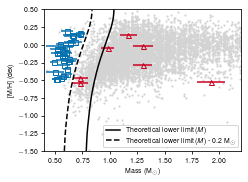

In [11]:
%matplotlib inline
from matplotlib.ticker import ScalarFormatter


gridspec_kw = {'left':0.17, 'right':0.96, 'top':0.96, 'bottom':0.15, 'wspace':0.2, 'hspace':0.2}
fig, axes = plt.subplots(figsize=nature_size('one',ratio=0.7), nrows=1, ncols=1, squeeze=False, gridspec_kw=gridspec_kw)
axes = axes.reshape(-1)


# Select all HeB stars
c=axes[0].scatter(stars.loc[oidx,'ClcorM'], stars.loc[oidx,'[M/H]'], marker='.', color='lightgray', s=5, rasterized=True)

c=axes[0].errorbar(stars.loc[lidx,'mass'], stars.loc[lidx,'[M/H]'], 
                   xerr=stars.loc[lidx,'e_mass'], ecolor=blue, 
                   mec=blue, mfc='none', ms=5, marker='s', linestyle='none')

c=axes[0].errorbar(stars.loc[uidx,'mass'], stars.loc[uidx,'[M/H]'], 
                   xerr=stars.loc[uidx,'e_mass'], ecolor=red, 
                   mec=red, mfc='none', ms=5, marker='^', linestyle='none')


# 13.8Gyr limit
ym = np.arange(-1.5, 0.5, 0.01)
xm = f_low_mini_limit(ym)
axes[0].plot(xm, ym, 'k-', label='Theoretical lower limit ($M$)')
axes[0].plot(xm-0.2, ym, 'k--', label='Theoretical lower limit ($M$) - 0.2 M$_\\odot$')

axes[0].set_xlim(0.4, 2.2)
axes[0].set_ylim(-1.5, 0.5)
axes[0].set_xlabel('Mass (M$_\\odot$)')
axes[0].set_ylabel('[M/H] (dex)')
axes[0].legend(fontsize=fontsize)

plt.savefig(overleaf_path+'Fig_main_2_mass_feh_diagram.pdf')